# *Monod* demonstration: fit to neural cell subtypes

In the current notebook, we run the *Monod* inference pipeline on eight pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types, using a common set of 3,000 genes, a $20\times 21$ grid, and four models (bursty, constitutive, extrinsic, and CIR-like).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *

We already know the sampling parameters for glutamatergic cells. Instead of scanning over a grid, just pull them in from previous search results.

In [12]:
dataset_meta = ['B08','C01','F08','H12']

subcluster_names = ['l23it','l5it','l6it','l5et', 'l56np', 'l6ct', 'l6b']
cluster_names = ['gaba','glu']
dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]   \
              + ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] 
loom_filepaths = ['/home/ggorin/count_data/loom_allen_celltype_kb/test/'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']

n_datasets = len(loom_filepaths)


In [13]:
dataset_names

['allen_B08_gaba',
 'allen_B08_glu',
 'allen_C01_gaba',
 'allen_C01_glu',
 'allen_F08_gaba',
 'allen_F08_glu',
 'allen_H12_gaba',
 'allen_H12_glu',
 'allen_B08_l23it',
 'allen_B08_l5it',
 'allen_B08_l6it',
 'allen_B08_l5et',
 'allen_B08_l56np',
 'allen_B08_l6ct',
 'allen_B08_l6b']

In [43]:
so = np.zeros((n_datasets,2))
for i in range(n_datasets):
    so[i] = so_[i//len(cluster_names)]

In [44]:
so

array([[-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -1.05      ],
       [-6.26315789, -1.05      ],
       [-6.26315789, -1.05      ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ],
       [-6.26315789, -0.9       ]])

## Preprocessing

Identify the genes to fit.

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_220602_022_allen_celltypes_1 created.
INFO:root:Dataset: allen_B08_gaba
INFO:root:1551 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7489 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba created.
INFO:root:Dataset: allen_B08_glu
INFO:root:4394 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7929 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220602_022_allen_celltypes_1/allen_B08_glu created.
INFO:root:Dataset: allen_C01_gaba
INFO:root:1704 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6284 genes retained after expression filter.
INFO:root:Directory ./fits/gg_220602_022_allen_celltypes_1/allen_C01_gaba created.
INFO:root:Dat

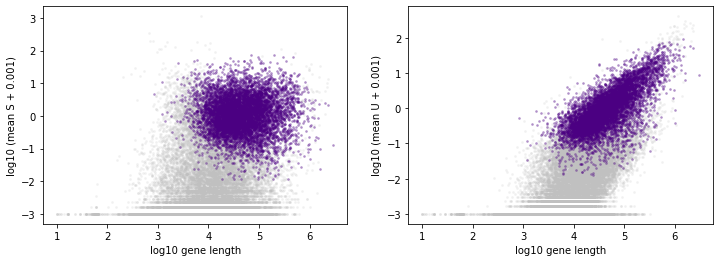

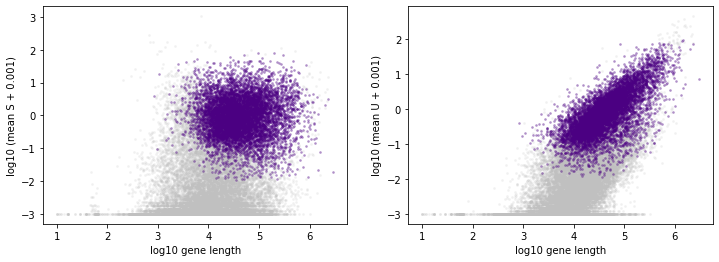

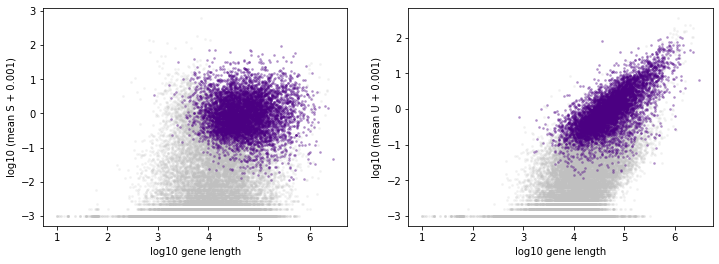

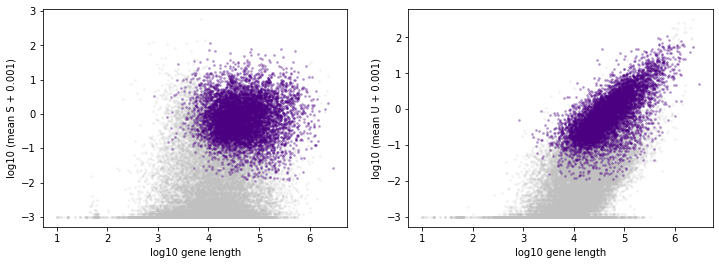

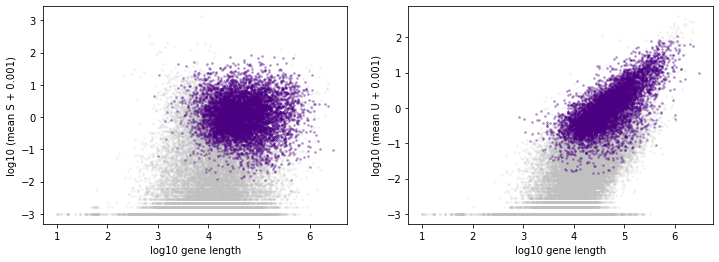

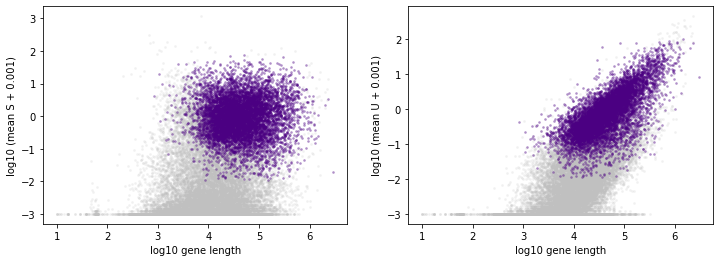

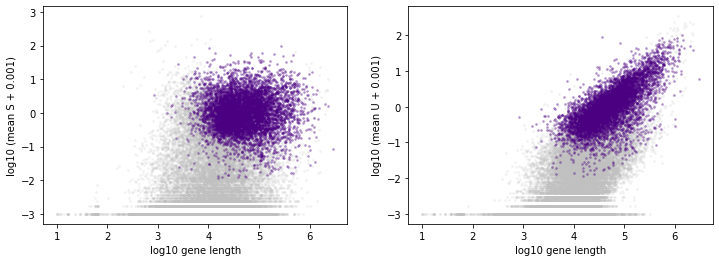

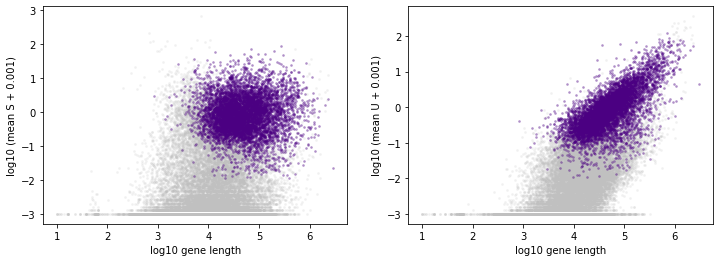

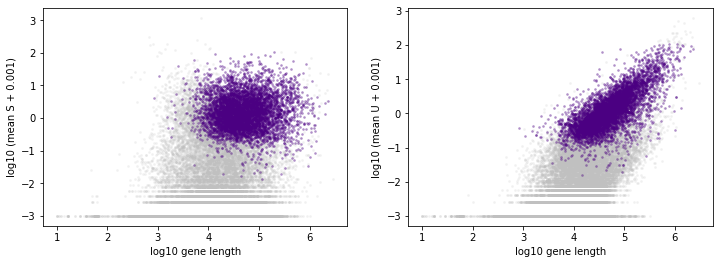

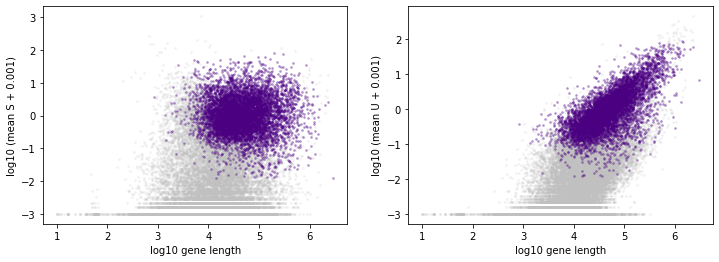

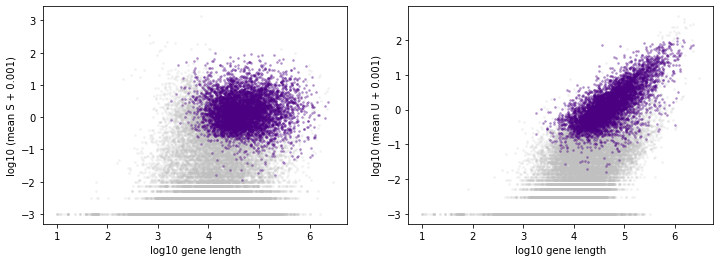

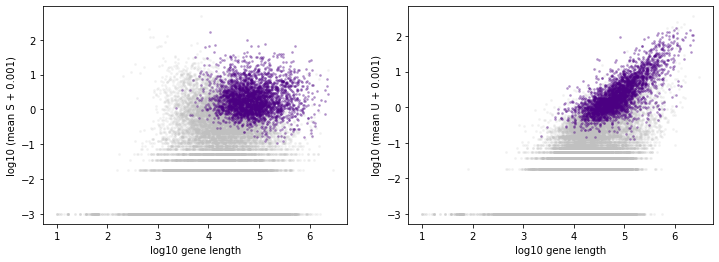

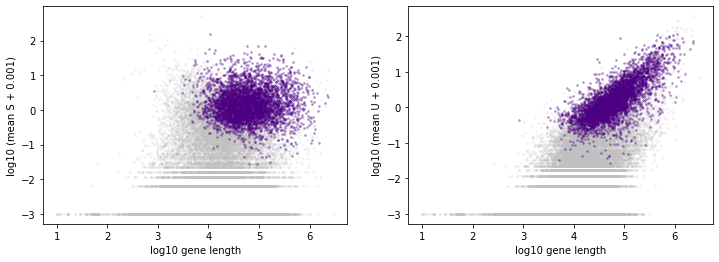

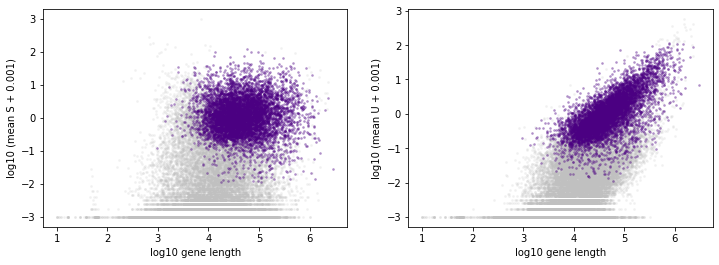

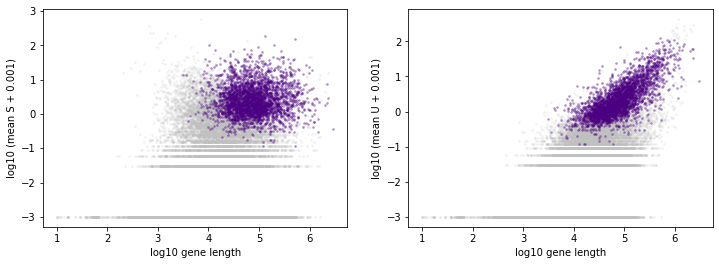

In [15]:
dir_string,dataset_strings = construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_celltypes',batch_id=1,\
                                             n_genes=3000)

## Inference

Define parameter bounds, then iterate over datasets and perform the fits.

In [ ]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-7.5, -2]
samp_ub = [-5.5, 0]
gridsize = [20,21]



result_strings = []
for i in range(n_datasets):
    fitmodel = CMEModel('Bursty','Poisson')
    inference_parameters = InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':1})
    search_data = extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names)
    full_result_string = inference_parameters.fit_all_grid_points(60,search_data)
    result_strings.append(full_result_string)

INFO:root:Directory ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_gaba
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220602_022_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_220602_022_allen_celltypes_1/allen_B08_gaba/raw.sd.
INFO:root:Starting parallelized grid scan.


In [ ]:
for i in range(n_datasets):
    sr = load_search_results(result_strings[i])
    sd = load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd'
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,viz=True) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    sr.update_on_disk()

In [ ]:
result_strings

In [8]:
# dataset_strings = ['./fits/gg_220601_022_allen_cellsubtypes_1/'+x for x in dataset_names]

In [9]:
# sd_strings = [x+'/raw.sd' for x in dataset_strings]

In [10]:
# Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
# Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


In [11]:
result_strings  = ['./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6ct/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l5it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l6it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l6ct/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l5it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_B08_l6ct/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l5it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l6it/Bursty_Poisson_1x1/grid_scan_results.res',
 './fits/gg_220601_022_allen_cellsubtypes_1/allen_C01_l6ct/Bursty_Poisson_1x1/grid_scan_results.res']

In [12]:
sr_arr = []
sd_arr = []


for j in range(n_datasets):
    sd = load_search_data(sd_strings[j])
    sr = load_search_results(result_strings[j])
    
    sd_arr.append(sd)
    sr_arr.append(sr)


INFO:root:Search data loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l5it/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6it/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6ct/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_A08_l6ct/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l5it/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220601_022_allen_cellsubtypes_1/allen_B01_l5it/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_2206

In [15]:
dir_string = './fits/gg_220601_022_allen_cellsubtypes_1'

In [16]:
make_batch_analysis_dir(sr_arr,dir_string)

In [17]:
#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


INFO:root:Figure stored to ./fits/gg_220601_022_allen_cellsubtypes_1/analysis_figures/kneeplots_all.png.


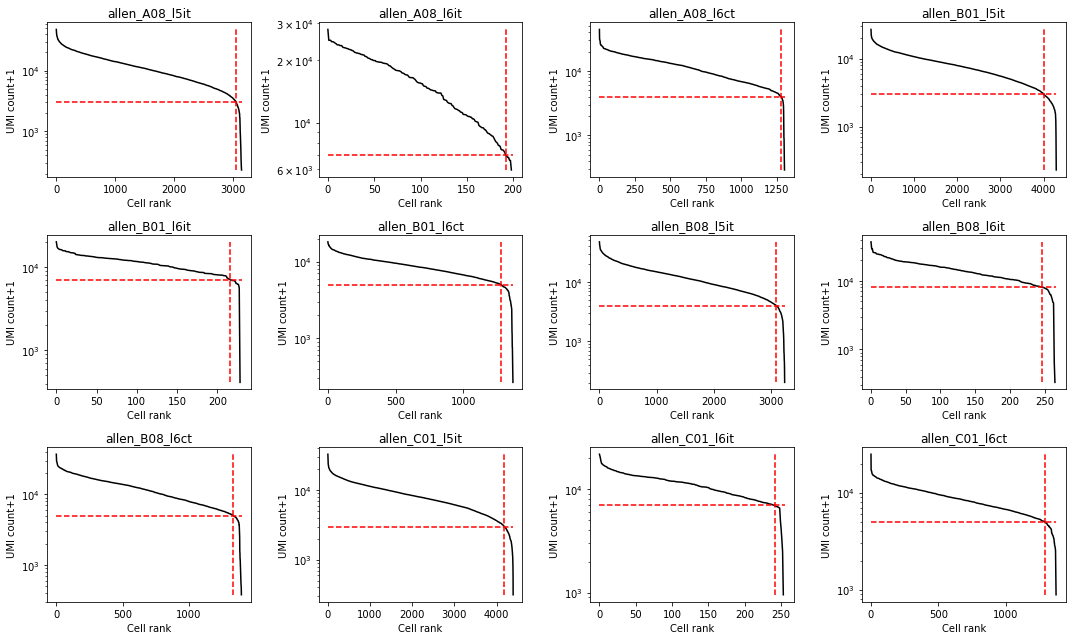

In [18]:
sz=(3,4)
fig1,ax1 = plt.subplots(sz[0],sz[1],figsize=(15,9))
thr = [3e3, 7e3, 4e3, 3e3, 
       7e3, 5e3, 4e3, 8e3,
       5e3, 3e3, 7e3, 5e3]
for j in range(n_datasets):
    axloc=np.unravel_index(j,sz)
    sd_arr[j].knee_plot(ax1=ax1[axloc],viz=True,thr=thr[j])
    ax1[axloc].set_title(dataset_names[j])
fig1.tight_layout()


analysis_dir_string = sr_arr[0].batch_analysis_string
fig_string = analysis_dir_string+'/kneeplots_all.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


In [124]:
from scipy import stats

In [227]:
ss.shape

(3140,)

In [226]:
sd_arr[0].S.shape

(3000, 3140)

In [325]:
dataset_names

['allen_A08_l5it',
 'allen_A08_l6it',
 'allen_A08_l6ct',
 'allen_B01_l5it',
 'allen_B01_l6it',
 'allen_B01_l6ct',
 'allen_B08_l5it',
 'allen_B08_l6it',
 'allen_B08_l6ct',
 'allen_C01_l5it',
 'allen_C01_l6it',
 'allen_C01_l6ct']

allen_A08_l5it
3140
3090
allen_A08_l6it
199
199
allen_A08_l6ct
1305
1296
allen_B01_l5it
4293
4236
allen_B01_l6it
229
227
allen_B01_l6ct
1367
1337
allen_B08_l5it
3243
3189
allen_B08_l6it
266
260
allen_B08_l6ct
1398
1382
allen_C01_l5it
4393
4285
allen_C01_l6it
254
249
allen_C01_l6ct
1375
1340


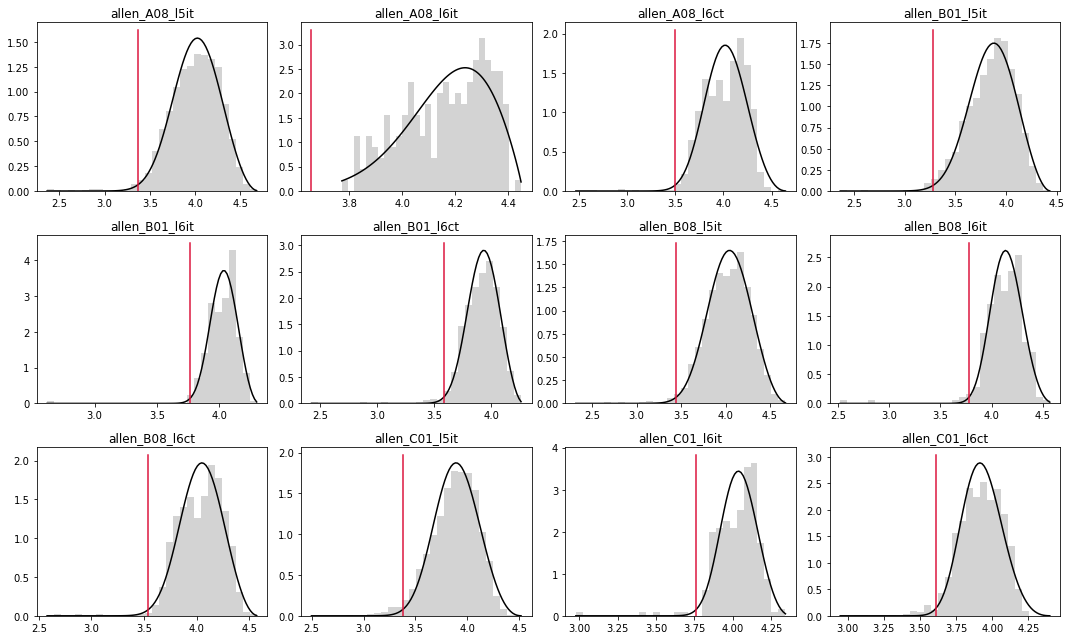

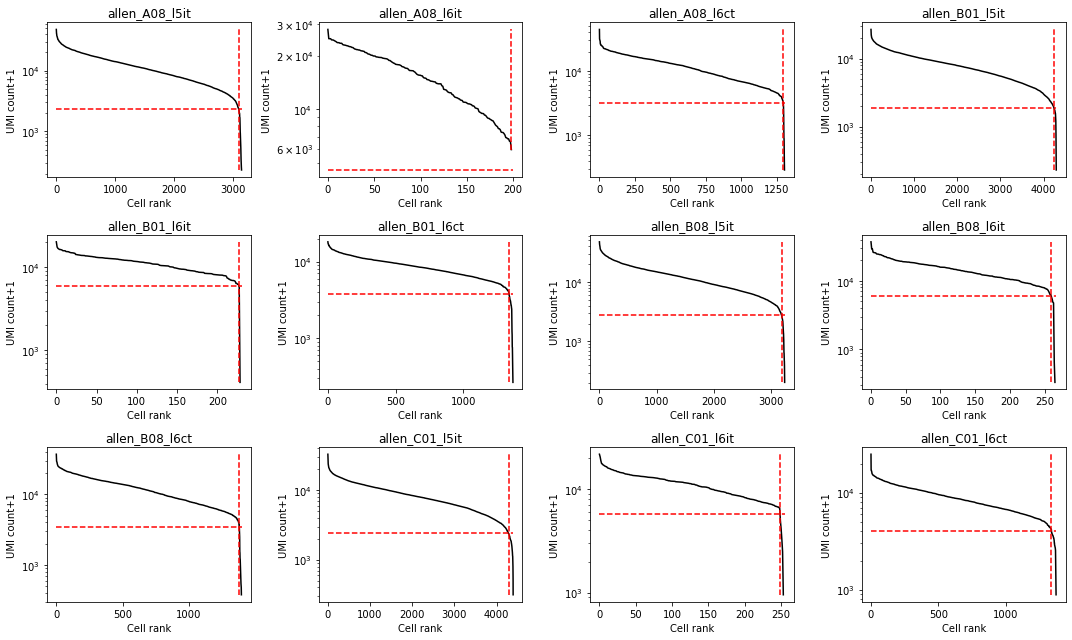

In [397]:
sz=(3,4)
fig1,ax1 = plt.subplots(sz[0],sz[1],figsize=(15,9))
fig2,ax2 = plt.subplots(sz[0],sz[1],figsize=(15,9))
for j in range(n_datasets):
    print(dataset_names[j])
    axloc=np.unravel_index(j,sz)
    
    ss = np.log10(sd_arr[j].S.sum(0)+1)
    fitlaw = scipy.stats.genextreme

    cf = np.ones(len(ss),dtype=bool)
    for _ in range(10):
        fitparams = fitlaw.fit(ss[cf])
        ppf = fitlaw.ppf([0.005,0.995],*fitparams)
        cf = (ss>ppf[0]) #& (ss<ppf[1])
    x = np.linspace(ss.min(),ss.max(),100)
    ax1[axloc].hist(ss,30,density=True,color='lightgray')
    p = fitlaw.pdf(x, *fitparams)
    ax1[axloc].plot(x,p,'k-')
    
    x=[ppf[0]]*2
    yl = ax1[axloc].get_ylim()
    ax1[axloc].plot(x,yl,'-',color='crimson')
    
    
    sd_arr[j].knee_plot(ax1=ax2[axloc],viz=True,thr=10**ppf[0])
    ax1[axloc].set_title(dataset_names[j])
    ax2[axloc].set_title(dataset_names[j])
    
    print(len(cf))
    print(cf.sum())
fig1.tight_layout()
fig2.tight_layout()

In [387]:
cf.sum()

3090

3140

In [389]:
ss[~cf].max()

3.3624825

In [33]:
f_tech_naive = []
f_mech = []
S_ = []

for j in range(n_datasets):
    f_tech_naive.append(sd_arr[j].get_noise_decomp(knee_thr=thr[j])[:,1,1])
    sr_arr[j].find_sampling_optimum()
    d = sr_arr[j].get_noise_decomp()
    f_mech.append(d[:,1,1]+ d[:,0,1]) # bio noise
    S_.append(sd_arr[j].S)
    
f_tech_naive = np.asarray(f_tech_naive)
f_mech = np.asarray(f_mech)


In [39]:
np.hstack((S_[0],S_[1])).shape

(3000, 3339)

In [40]:
dataset_names

['allen_A08_l5it',
 'allen_A08_l6it',
 'allen_A08_l6ct',
 'allen_B01_l5it',
 'allen_B01_l6it',
 'allen_B01_l6ct',
 'allen_B08_l5it',
 'allen_B08_l6it',
 'allen_B08_l6ct',
 'allen_C01_l5it',
 'allen_C01_l6it',
 'allen_C01_l6ct']

In [69]:
varg = []
vclus = []
for j in range(4):
    S_d = np.hstack((S_[3*j],S_[3*j+1], S_[3*j+2]))
    v = S_d.var(1)
    
    fcell = np.asarray([x.shape[1] for x in (S_[3*j],S_[3*j+1], S_[3*j+2])])/S_d.shape[1]
    varg.append(v)
    vc = np.var(np.asarray([S_[3*j].mean(1),S_[3*j+1].mean(1), S_[3*j+2].mean(1)])*fcell[:,None],0)
    vclus.append(vc)
varg = np.asarray(varg)
vclus = np.asarray(vclus)

In [70]:
f_tech_ = f_tech_naive[[0,3,6,9]]

In [71]:
f_tech_

array([[0.36159313, 0.64855975, 0.27766651, ..., 0.29235029, 0.21888161,
        0.48059601],
       [0.23339665, 0.57334033, 0.20591289, ..., 0.1454739 , 0.14586335,
        0.31832922],
       [0.39956856, 0.64917463, 0.28964782, ..., 0.29504699, 0.2611565 ,
        0.52632862],
       [0.22214216, 0.59035978, 0.19873071, ..., 0.19123691, 0.16928732,
        0.33721071]])

In [100]:
f_mech.shape

(12, 3000)

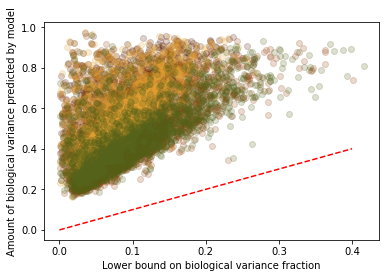

In [113]:
for j in range(4):
    S_d = np.hstack((S_[3*j],S_[3*j+1], S_[3*j+2])).mean(1)
    x = vclus[j]/varg[j]
    y = f_mech[j*3]
    q = np.quantile(S_d,0)
    gf = S_d>q
    plt.scatter(x[gf],y[gf],color=Degas[j],alpha=0.2)
    xl = [0,0.4]
plt.xlabel('Lower bound on biological variance fraction')
plt.ylabel('Amount of biological variance predicted by model')
plt.plot(xl,xl,'r--')

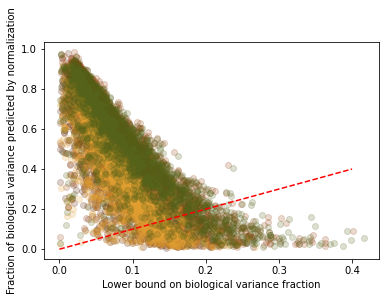

In [112]:
for j in range(4):
    S_d = np.hstack((S_[3*j],S_[3*j+1], S_[3*j+2])).mean(1)
    x = vclus[j]/varg[j]
    y = 1-f_tech_[j]
    q = np.quantile(S_d,0)
    gf = S_d>q
    plt.scatter(x[gf],y[gf],color=Degas[j],alpha=0.2)
    xl = [0,0.4]
plt.xlabel('Lower bound on biological variance fraction')
plt.ylabel('Fraction of biological variance predicted by normalization')
plt.plot(xl,xl,'r--')

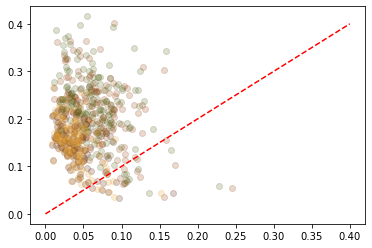

In [93]:
for j in range(4):
    S_d = np.hstack((S_[3*j],S_[3*j+1], S_[3*j+2])).mean(1)
    x = 1-f_tech_[j]
    y = vclus[j]/varg[j]
    q = np.quantile(S_d,0.95)
    gf = S_d>q
    plt.scatter(x[gf],y[gf],color=Degas[j],alpha=0.2)
    xl = [0,0.4]
plt.plot(xl,xl,'r--')

In [85]:
q

3.6023580074310306

In [82]:
S_d[gf]

array([0.73630023, 0.69926935, 0.90169376, ..., 0.6532713 , 0.5984723 ,
       1.1492859 ], dtype=float32)

Text(0, 0.5, 'Density')

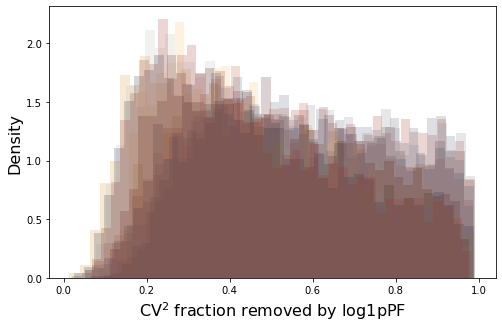

In [20]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.hist(f_tech_naive[j],nbin,alpha=0.2,density=True,facecolor=c,label=dataset_names[j])
plt.xlabel(r'CV$^2$ fraction removed by log1pPF',fontsize=fs)
plt.ylabel('Density',fontsize=fs)
# plt.legend()


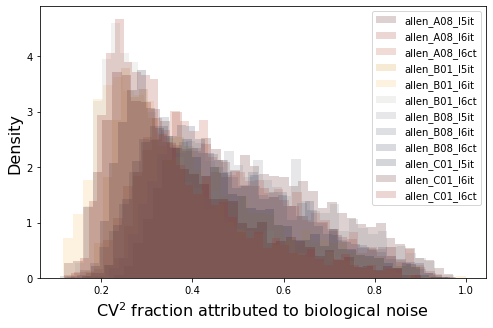

In [21]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.hist(f_mech[j],nbin,alpha=0.2,density=True,facecolor=c,label=dataset_names[j])
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
# plt.xlabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.ylabel('Density',fontsize=fs)
plt.legend()


INFO:root:Figure stored to ./fits/gg_220601_022_allen_cellsubtypes_1/analysis_figures/CV2_noise.png.


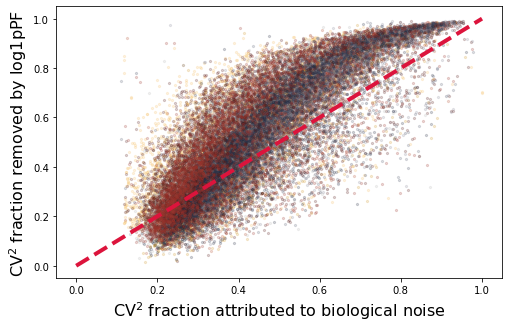

In [22]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(f_mech[j],f_tech_naive[j],s=5,alpha=0.2,c=c)
plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4)
# plt.xlabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction removed by log1pPF',fontsize=fs)

fig_string = analysis_dir_string+'/CV2_noise.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


In [23]:
Svar = []
for j in range(n_datasets):
    Svar.append([x['S_var'] for x in sd_arr[j].moments])
Svar = np.asarray(Svar)

In [24]:
Smean = []
for j in range(n_datasets):
    Smean.append([x['S_mean'] for x in sd_arr[j].moments])
Smean = np.asarray(Smean)

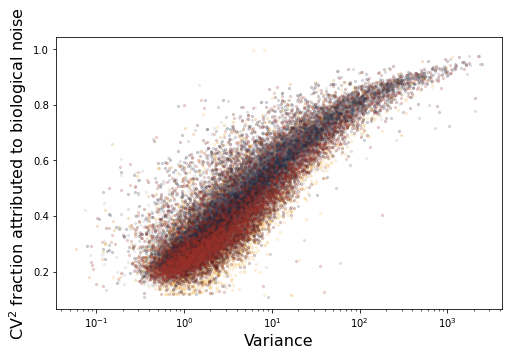

In [25]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Svar[j],f_mech[j],s=5,alpha=0.2,c=c)
# plt.ylabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.xlabel(r'Variance',fontsize=fs)
plt.xscale('log')


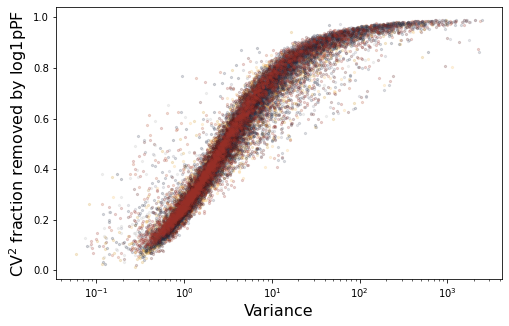

In [26]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Svar[j],f_tech_naive[j],s=5,alpha=0.2,c=c)
plt.ylabel(r'CV$^2$ fraction removed by log1pPF',fontsize=fs)
plt.xlabel(r'Variance',fontsize=fs)
plt.xscale('log')


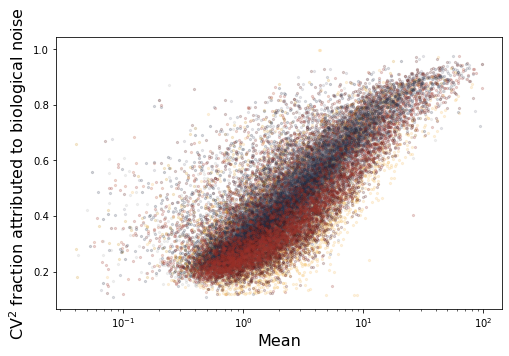

In [27]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Smean[j],f_mech[j],s=5,alpha=0.2,c=c)
# plt.ylabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.xlabel(r'Mean',fontsize=fs)
plt.xscale('log')

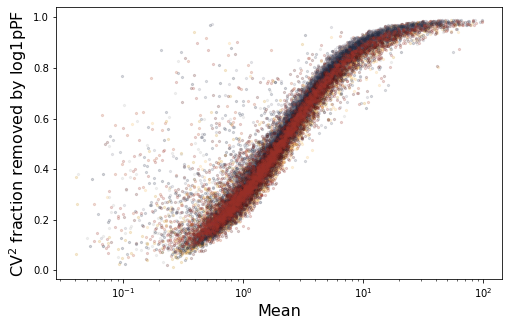

In [28]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Smean[j],f_tech_naive[j],s=5,alpha=0.2,c=c)
# plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4)
# plt.ylabel(r'CV$^2$ fraction attributed to technical noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction removed by log1pPF',fontsize=fs)
plt.xlabel(r'Mean',fontsize=fs)
plt.xscale('log')

# fig_string = analysis_dir_string+'/CV2_noise.png'
# plt.savefig(fig_string,dpi=450)
# log.info('Figure stored to {}.'.format(fig_string))


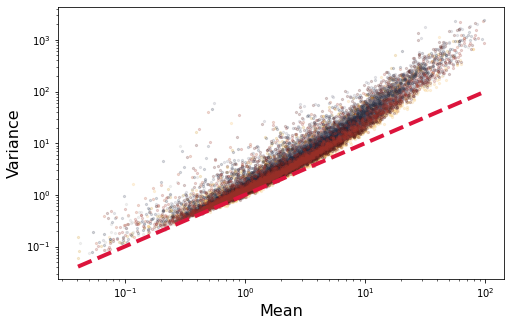

In [29]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Smean[j],Svar[j],s=5,alpha=0.2,c=c)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'Variance',fontsize=fs)
plt.xlabel(r'Mean',fontsize=fs)
xl = [Smean.min(),Smean.max()]
plt.plot(xl,xl,'--',c='crimson',linewidth=4)


Text(0, 0.5, 'Fano')

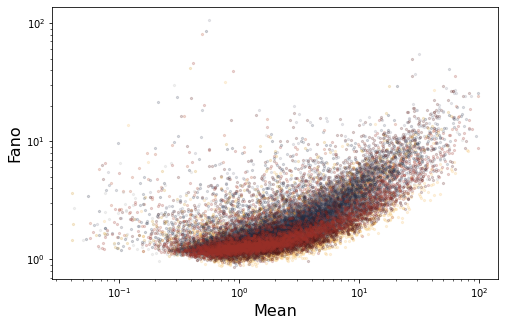

In [30]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    c = Demuth[j%len(Demuth)]
    plt.scatter(Smean[j],Svar[j]/Smean[j],s=5,alpha=0.2,c=c)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Mean',fontsize=fs)
plt.ylabel(r'Fano',fontsize=fs)


(12, 3000)